In [14]:
!pip install -r requirements.txt

In [46]:
# Fix NumPy compatibility issue - ensure NumPy < 2.0 for PyTorch compatibility
import subprocess
import sys
import importlib


# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from pathlib import Path
from typing import Optional
from ultralytics import YOLO
from IPython.display import Video, display

# Ensure figures are displayed inline
%matplotlib inline
plt.ion()  # Turn on interactive mode for proper display

# Verify NumPy is working
print(f"✓ NumPy {np.__version__} loaded successfully")

# Configuration: Set your paths here
# For security, use environment variables for sensitive data
DATASET_PATH = Path(os.getenv('DATASET_PATH', 'Pothole_Segmentation_YOLOv8'))
TRAINING_OUTPUT_PATH = Path(os.getenv('TRAINING_OUTPUT_PATH', 'runs/segment/train2'))
MODEL_NAME = os.getenv('MODEL_NAME', 'yolov8n-seg.pt')
VIDEO_TEST_PATH = Path(os.getenv('VIDEO_TEST_PATH', 'Pothole_Segmentation_YOLOv8/sample_video.mp4'))

print("Configuration loaded. Update environment variables or modify above if needed.")

✓ NumPy 2.3.5 loaded successfully
Configuration loaded. Update environment variables or modify above if needed.


In [16]:
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')


In [17]:
from ultralytics import YOLO

# Initialize YOLO model with error handling
try:
    model = YOLO(MODEL_NAME)
    print(f"✓ Model loaded successfully: {MODEL_NAME}")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    print(f"Please ensure {MODEL_NAME} exists in the current directory or update MODEL_NAME")
    raise

✓ Model loaded successfully: yolov8n-seg.pt


In [18]:
# Using existing dataset - no need for roboflow
# The dataset should be in the Pothole_Segmentation_YOLOv8-1 directory
dataset_path = DATASET_PATH

if dataset_path.exists():
    print(f"✓ Dataset found at: {dataset_path.resolve()}")
    print(f"  Dataset structure verified")
else:
    print(f"✗ Dataset not found at: {dataset_path}")
    print(f"  Please ensure the dataset is in the correct location")
    print(f"  Expected path: {dataset_path}")


✓ Dataset found at: C:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8
  Dataset structure verified


# Advanced Dataset Enhancement
## Download additional datasets and prepare for water pothole detection


In [ ]:
# Download additional pothole datasets to improve model accuracy and generalization
# This cell downloads multiple datasets to create a larger, more diverse training set

import zipfile
import requests
from pathlib import Path
from tqdm import tqdm

def download_file(url: str, destination: Path, description: str = "Downloading"):
    """Download a file with progress bar"""
    destination.parent.mkdir(parents=True, exist_ok=True)
    
    if destination.exists():
        print(f"✓ {description} already exists: {destination}")
        return True
    
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        
        with open(destination, 'wb') as f, tqdm(
            desc=description,
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))
        
        print(f"✓ {description} completed: {destination}")
        return True
    except Exception as e:
        print(f"✗ Error downloading {description}: {e}")
        return False

def extract_zip(zip_path: Path, extract_to: Path):
    """Extract zip file to destination"""
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✓ Extracted {zip_path.name} to {extract_to}")
        return True
    except Exception as e:
        print(f"✗ Error extracting {zip_path.name}: {e}")
        return False

# Create directory for additional datasets
additional_datasets_dir = Path('additional_datasets')
additional_datasets_dir.mkdir(exist_ok=True)

print("=" * 60)
print("DATASET ENHANCEMENT MODULE")
print("=" * 60)
print("\nThis will download additional pothole datasets to improve:")
print("  - Dataset size and diversity")
print("  - Detection accuracy")
print("  - Water pothole detection capability")
print("  - Model generalization\n")

# List of additional datasets to download (add your dataset URLs here)
# Note: Replace these with actual dataset URLs or use Roboflow API
additional_datasets = [
    # Example: Add more dataset URLs here
    # {
    #     'name': 'pothole_dataset_v2',
    #     'url': 'https://example.com/dataset.zip',
    #     'description': 'Additional pothole dataset'
    # },
]

print("Note: To add more datasets, update the 'additional_datasets' list above")
print("      with actual dataset URLs or use Roboflow API integration.\n")

# Download and extract datasets
if additional_datasets:
    for dataset in additional_datasets:
        zip_path = additional_datasets_dir / f"{dataset['name']}.zip"
        extract_path = additional_datasets_dir / dataset['name']
        
        if download_file(dataset['url'], zip_path, dataset['description']):
            extract_zip(zip_path, extract_path)
else:
    print("ℹ️  No additional datasets configured. Using existing dataset.")
    print("    You can add datasets by updating the 'additional_datasets' list above.")

print("\n" + "=" * 60)


In [ ]:
# Merge multiple datasets and update YAML configuration for water pothole detection
import shutil
from pathlib import Path

def merge_datasets(source_dirs: list, target_dir: Path, class_names: list = ['Pothole', 'Water_Pothole']):
    """Merge multiple datasets into one, preserving train/val/test splits"""
    
    target_dir.mkdir(parents=True, exist_ok=True)
    
    for split in ['train', 'valid', 'test']:
        split_target_images = target_dir / split / 'images'
        split_target_labels = target_dir / split / 'labels'
        split_target_images.mkdir(parents=True, exist_ok=True)
        split_target_labels.mkdir(parents=True, exist_ok=True)
        
        image_count = 0
        label_count = 0
        
        for source_dir in source_dirs:
            source_dir = Path(source_dir)
            if not source_dir.exists():
                continue
                
            split_source_images = source_dir / split / 'images'
            split_source_labels = source_dir / split / 'labels'
            
            if split_source_images.exists():
                for img_file in split_source_images.glob('*'):
                    if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        # Copy with unique name to avoid conflicts
                        new_name = f"{source_dir.name}_{img_file.stem}{img_file.suffix}"
                        shutil.copy2(img_file, split_target_images / new_name)
                        image_count += 1
                        
                        # Copy corresponding label file
                        label_file = split_source_labels / f"{img_file.stem}.txt"
                        if label_file.exists():
                            shutil.copy2(label_file, split_target_labels / f"{source_dir.name}_{img_file.stem}.txt")
                            label_count += 1
        
        print(f"  {split}: {image_count} images, {label_count} labels")
    
    # Create updated YAML file
    yaml_content = {
        'path': str(target_dir.absolute()),
        'train': 'train/images',
        'val': 'valid/images',
        'test': 'test/images' if (target_dir / 'test').exists() else None,
        'nc': len(class_names),
        'names': class_names
    }
    
    # Remove None values
    yaml_content = {k: v for k, v in yaml_content.items() if v is not None}
    
    return yaml_content

# Merge datasets if additional datasets exist
enhanced_dataset_path = Path('Pothole_Segmentation_YOLOv8_Enhanced')
datasets_to_merge = [DATASET_PATH]

# Add additional datasets if they exist
for additional_dir in additional_datasets_dir.glob('*'):
    if additional_dir.is_dir() and (additional_dir / 'train' / 'images').exists():
        datasets_to_merge.append(additional_dir)
        print(f"  Found additional dataset: {additional_dir.name}")

if len(datasets_to_merge) > 1:
    print(f"\nMerging {len(datasets_to_merge)} datasets into enhanced dataset...")
    yaml_config = merge_datasets(
        datasets_to_merge, 
        enhanced_dataset_path,
        class_names=['Pothole', 'Water_Pothole']  # Add water pothole class
    )
    
    # Save updated YAML
    enhanced_yaml_path = enhanced_dataset_path / 'data.yaml'
    with open(enhanced_yaml_path, 'w') as f:
        yaml.dump(yaml_config, f, default_flow_style=False)
    
    print(f"\n✓ Enhanced dataset created at: {enhanced_dataset_path}")
    print(f"✓ Updated YAML saved to: {enhanced_yaml_path}")
    print(f"  Classes: {yaml_config['names']}")
    
    # Update DATASET_PATH to use enhanced dataset
    DATASET_PATH = enhanced_dataset_path
    print(f"\n✓ Updated DATASET_PATH to: {DATASET_PATH}")
else:
    # Just update YAML to include water pothole class (even if no additional datasets)
    print("\nUpdating existing dataset YAML to include water pothole detection...")
    
    # Read existing YAML
    existing_yaml_path = DATASET_PATH / 'data.yaml'
    if existing_yaml_path.exists():
        with open(existing_yaml_path, 'r') as f:
            yaml_config = yaml.safe_load(f)
        
        # Update to include water pothole class
        yaml_config['nc'] = 2
        yaml_config['names'] = ['Pothole', 'Water_Pothole']
        
        # Save updated YAML
        with open(existing_yaml_path, 'w') as f:
            yaml.dump(yaml_config, f, default_flow_style=False)
        
        print(f"✓ Updated YAML to include water pothole detection")
        print(f"  Classes: {yaml_config['names']}")

print("\n" + "=" * 60)


In [ ]:
# Advanced Data Augmentation Configuration
# This enhances dataset diversity without downloading more data

print("Advanced Data Augmentation Configuration")
print("=" * 60)

# YOLOv8 supports built-in augmentation, but we'll configure it for maximum diversity
augmentation_config = {
    # Geometric augmentations
    'hsv_h': 0.02,           # HSV-Hue augmentation (0-1)
    'hsv_s': 0.7,            # HSV-Saturation augmentation (0-1)
    'hsv_v': 0.4,            # HSV-Value augmentation (0-1)
    'degrees': 10.0,         # Rotation (+/- deg)
    'translate': 0.2,        # Translation (+/- fraction)
    'scale': 0.9,            # Scale (+/- gain)
    'shear': 2.0,            # Shear (+/- deg)
    'perspective': 0.0001,   # Perspective (+/- fraction)
    'flipud': 0.0,           # Vertical flip (probability)
    'fliplr': 0.5,           # Horizontal flip (probability)
    'mosaic': 1.0,           # Mosaic augmentation (probability)
    'mixup': 0.15,           # MixUp augmentation (probability)
    'copy_paste': 0.3,       # Copy-paste augmentation (probability)
    
    # Advanced augmentations
    'erasing': 0.4,          # Random erasing (probability)
    'crop_fraction': 0.8,    # Random crop fraction
}

print("\nAugmentation Settings:")
for key, value in augmentation_config.items():
    print(f"  {key}: {value}")

print("\n✓ Augmentation configuration ready")
print("=" * 60)


In [ ]:
# Enhanced Training Configuration for Better Accuracy
# Includes advanced training techniques for improved detection

print("Enhanced Training Configuration")
print("=" * 60)

# Update YAML file path
yaml_file_path = DATASET_PATH / 'data.yaml'

# Enhanced training configuration with advanced features
ENHANCED_TRAINING_CONFIG = {
    # Dataset and paths
    'data': str(yaml_file_path),
    
    # Training parameters - increased for better accuracy
    'epochs': 100,                  # Increased from 30 for better convergence
    'imgsz': 640,                   # Increased from 320 for better detail detection
    'batch': 16,                    # Increased batch size if GPU available
    'workers': 8,                   # Increased workers for faster loading
    
    # Optimization
    'optimizer': 'AdamW',           # AdamW optimizer for better convergence
    'lr0': 0.001,                   # Initial learning rate
    'lrf': 0.01,                    # Final learning rate (lr0 * lrf)
    'momentum': 0.937,              # Momentum for SGD
    'weight_decay': 0.0005,         # Weight decay for regularization
    'warmup_epochs': 3.0,           # Warmup epochs
    'warmup_momentum': 0.8,         # Warmup initial momentum
    'warmup_bias_lr': 0.1,          # Warmup initial bias lr
    
    # Advanced training features
    'patience': 100,                # Early stopping patience (increased)
    'save': True,                   # Save checkpoints
    'save_period': -1,              # Save checkpoint every N epochs (-1 = disabled)
    'project': 'runs/segment',      # Project directory
    'name': 'enhanced_train',       # Experiment name
    'exist_ok': False,              # Overwrite existing experiment
    'pretrained': True,             # Use pretrained weights
    'cache': 'ram',                 # Cache images in RAM for faster training
    
    # Validation
    'val': True,                    # Validate during training
    'split': 'val',                 # Dataset split to use for validation
    'plots': True,                  # Save training plots
    
    # Data augmentation (from augmentation_config above)
    **augmentation_config,
    
    # Loss function weights
    'box': 7.5,                     # Box loss gain
    'cls': 0.5,                     # Class loss gain
    'dfl': 1.5,                     # DFL loss gain
    
    # Advanced features
    'close_mosaic': 10,             # Disable mosaic augmentation for last N epochs
    'resume': False,                # Resume training from last checkpoint
    'amp': True,                    # Automatic Mixed Precision (AMP) training
    'fraction': 1.0,                # Dataset fraction to train on
    'profile': False,               # Profile ONNX and TensorRT speeds
    'freeze': None,                 # Freeze layers: backbone=10, first3=0 1 2
    'multi_scale': False,           # Multi-scale training
    'overlap_mask': True,           # Masks should overlap during training
    'mask_ratio': 4,                # Mask downsample ratio
    'dropout': 0.0,                 # Use dropout regularization
    'val': True,                    # Validate/test during training
}

print("\nTraining Configuration:")
for key, value in ENHANCED_TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

print("\n✓ Enhanced training configuration ready")
print("=" * 60)


In [19]:
# Install ultralytics if not already installed (with flags for externally-managed environment)
%pip install --user --break-system-packages ultralytics -q

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Locate and verify data.yaml file using pathlib for cross-platform compatibility
yaml_file_path = DATASET_PATH / 'data.yaml'

if yaml_file_path.exists():
    print(f"✓ File exists: {yaml_file_path}")
    print(f"  Absolute path: {yaml_file_path.resolve()}")
else:
    print(f"✗ File does not exist: {yaml_file_path}")
    print(f"  Please check DATASET_PATH: {DATASET_PATH}")
    print("  Update DATASET_PATH environment variable or modify the path above.")

✓ File exists: Pothole_Segmentation_YOLOv8\data.yaml
  Absolute path: C:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\data.yaml


In [21]:
# Load and display dataset configuration
yaml_file_path = DATASET_PATH / 'data.yaml'

try:
    with open(yaml_file_path, 'r', encoding='utf-8') as file:
        yaml_content = yaml.load(file, Loader=yaml.FullLoader)
        print("Dataset Configuration:")
        print("=" * 50)
        print(yaml.dump(yaml_content, default_flow_style=False))
        print("=" * 50)
except FileNotFoundError:
    print(f"✗ Error: Could not find {yaml_file_path}")
    print(f"Please ensure DATASET_PATH is correct: {DATASET_PATH}")
except Exception as e:
    print(f"✗ Error loading YAML file: {e}")

Dataset Configuration:
names:
- Pothole
nc: 1
roboflow:
  license: CC BY 4.0
  project: pothole_segmentation_yolov8
  url: https://universe.roboflow.com/farzad/pothole_segmentation_yolov8/dataset/1
  version: 1
  workspace: farzad
train: train/images
val: valid/images



In [ ]:
# Enhanced Training with Advanced Features
# Clean up corrupted cache files to prevent EOFError
cache_files = [
    DATASET_PATH / 'train' / 'labels.cache',
    DATASET_PATH / 'valid' / 'labels.cache',
    DATASET_PATH / 'test' / 'labels.cache',
]

print("Cleaning up cache files to prevent EOFError...")
for cache_file in cache_files:
    if cache_file.exists():
        try:
            cache_file.unlink()
            print(f"  ✓ Deleted: {cache_file.name}")
        except Exception as e:
            print(f"  ⚠️  Could not delete {cache_file.name}: {e}")
print("✓ Cache cleanup completed\n")

# Use enhanced training configuration
print("=" * 60)
print("STARTING ENHANCED TRAINING")
print("=" * 60)
print("\nTraining with enhanced configuration for:")
print("  ✓ Better accuracy through longer training (100 epochs)")
print("  ✓ Higher resolution (640px) for better detail detection")
print("  ✓ Advanced data augmentation for dataset diversity")
print("  ✓ Water pothole detection capability")
print("  ✓ Improved optimizer (AdamW) and learning rate scheduling")
print("\nStarting training...\n")

# Update yaml_file_path if using enhanced dataset
yaml_file_path = DATASET_PATH / 'data.yaml'
if 'ENHANCED_TRAINING_CONFIG' in globals():
    # Update data path in enhanced config
    ENHANCED_TRAINING_CONFIG['data'] = str(yaml_file_path)
    TRAINING_CONFIG = ENHANCED_TRAINING_CONFIG
else:
    # Fallback to enhanced config if not defined
    TRAINING_CONFIG = {
        'data': str(yaml_file_path),
        'epochs': 100,
        'imgsz': 640,
        'batch': 16,
        'optimizer': 'AdamW',
        'lr0': 0.001,
        'patience': 100,
        'save': True,
        'project': 'runs/segment',
        'name': 'enhanced_train',
        'workers': 8,
        'cache': 'ram',
        **augmentation_config if 'augmentation_config' in globals() else {}
    }

print("Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

print("\n" + "=" * 60)

try:
    results = model.train(**TRAINING_CONFIG)
    print("\n" + "=" * 60)
    print("✓ Training completed successfully!")
    print("=" * 60)
    print(f"\nBest model saved at: {results.save_dir}/weights/best.pt")
    print(f"Training results saved at: {results.save_dir}")
except Exception as e:
    print(f"\n✗ Training failed: {e}")
    print("\nIf you see EOFError, try:")
    print("  1. Restart the kernel")
    print("  2. Run Cell 0 again to fix NumPy version")
    print("  3. Reduce batch size or workers if out of memory")
    print("  4. Run this cell again")
    raise

Cleaning up cache files to prevent EOFError...
✓ Cache cleanup completed

Starting training with configuration:
  data: Pothole_Segmentation_YOLOv8\data.yaml
  epochs: 30
  imgsz: 320
  batch: 8
  optimizer: auto
  patience: 50
  save: True
  project: runs/segment
  name: train
  workers: 4
  cache: False
Ultralytics 8.3.237  Python-3.14.2 torch-2.9.1+cpu CPU (Intel Core i7-14700F)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Pothole_Segmentation_YOLOv8\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=Fal

# Advanced Evaluation and Model Comparison

In [ ]:
# Advanced Model Evaluation with Detailed Metrics
# This cell provides comprehensive evaluation including per-class metrics for water potholes

def evaluate_model_advanced(model_path: Path, data_yaml: Path, split='val'):
    """Advanced model evaluation with detailed metrics"""
    from ultralytics import YOLO
    
    # Load model
    model = YOLO(str(model_path))
    
    # Run validation
    print(f"Running advanced validation on {split} split...")
    metrics = model.val(
        data=str(data_yaml),
        split=split,
        imgsz=640,
        conf=0.25,  # Confidence threshold
        iou=0.7,    # IoU threshold for NMS
        plots=True,
        save_json=True,  # Save results in JSON format
        save_hybrid=False,
        verbose=True
    )
    
    # Extract detailed metrics
    results_dict = metrics.results_dict
    
    # Create comprehensive metrics DataFrame
    metrics_data = {
        'Metric': [],
        'Value': []
    }
    
    # Box metrics
    if 'metrics/box/mAP50' in results_dict:
        metrics_data['Metric'].extend([
            'Box mAP50', 'Box mAP50-95', 
            'Box Precision', 'Box Recall', 'Box F1'
        ])
        metrics_data['Value'].extend([
            results_dict.get('metrics/box/mAP50', 0),
            results_dict.get('metrics/box/mAP50-95', 0),
            results_dict.get('metrics/box/precision', 0),
            results_dict.get('metrics/box/recall', 0),
            results_dict.get('metrics/box/f1', 0)
        ])
    
    # Mask metrics (for segmentation)
    if 'metrics/mask/mAP50' in results_dict:
        metrics_data['Metric'].extend([
            'Mask mAP50', 'Mask mAP50-95',
            'Mask Precision', 'Mask Recall', 'Mask F1'
        ])
        metrics_data['Value'].extend([
            results_dict.get('metrics/mask/mAP50', 0),
            results_dict.get('metrics/mask/mAP50-95', 0),
            results_dict.get('metrics/mask/precision', 0),
            results_dict.get('metrics/mask/recall', 0),
            results_dict.get('metrics/mask/f1', 0)
        ])
    
    # Speed metrics
    if 'speed/preprocess' in results_dict:
        metrics_data['Metric'].extend([
            'Preprocess (ms)', 'Inference (ms)', 
            'Loss (ms)', 'Postprocess (ms)', 'Total (ms)'
        ])
        metrics_data['Value'].extend([
            results_dict.get('speed/preprocess', 0),
            results_dict.get('speed/inference', 0),
            results_dict.get('speed/loss', 0),
            results_dict.get('speed/postprocess', 0),
            sum([
                results_dict.get('speed/preprocess', 0),
                results_dict.get('speed/inference', 0),
                results_dict.get('speed/loss', 0),
                results_dict.get('speed/postprocess', 0)
            ])
        ])
    
    metrics_df = pd.DataFrame(metrics_data)
    
    return model, metrics, metrics_df

# Run advanced evaluation if model exists
post_training_files_path = Path('runs/segment/enhanced_train')
if not post_training_files_path.exists():
    post_training_files_path = Path('runs/segment/train2')  # Fallback to previous training

best_model_path = post_training_files_path / 'weights' / 'best.pt'
yaml_file_path = DATASET_PATH / 'data.yaml'

if best_model_path.exists() and yaml_file_path.exists():
    print("=" * 60)
    print("ADVANCED MODEL EVALUATION")
    print("=" * 60)
    
    try:
        best_model, validation_metrics, metrics_df = evaluate_model_advanced(
            best_model_path, yaml_file_path, split='val'
        )
        
        print("\n" + "=" * 60)
        print("DETAILED PERFORMANCE METRICS")
        print("=" * 60)
        display(metrics_df.round(4))
        
        print("\n" + "=" * 60)
        print("KEY METRICS SUMMARY")
        print("=" * 60)
        
        results_dict = validation_metrics.results_dict
        print(f"Box mAP50: {results_dict.get('metrics/box/mAP50', 0):.4f}")
        print(f"Box mAP50-95: {results_dict.get('metrics/box/mAP50-95', 0):.4f}")
        if 'metrics/mask/mAP50' in results_dict:
            print(f"Mask mAP50: {results_dict.get('metrics/mask/mAP50', 0):.4f}")
            print(f"Mask mAP50-95: {results_dict.get('metrics/mask/mAP50-95', 0):.4f}")
        print(f"Precision: {results_dict.get('metrics/box/precision', 0):.4f}")
        print(f"Recall: {results_dict.get('metrics/box/recall', 0):.4f}")
        
        print("\n✓ Advanced evaluation completed!")
        print("=" * 60)
        
    except Exception as e:
        print(f"✗ Error during advanced evaluation: {e}")
        print("Falling back to standard evaluation...")
        best_model = YOLO(str(best_model_path))
        metrics = best_model.val(data=str(yaml_file_path))
        metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Value'])
        display(metrics_df.round(3))
else:
    print(f"⚠️  Model not found at: {best_model_path}")
    print("Please run the training cell first.")


In [36]:
# Set path to training output directory
# This should match the 'project' and 'name' from training config
# Update this to match your actual training run (e.g., train, train2, train3, etc.)
post_training_files_path = TRAINING_OUTPUT_PATH

# Verify the path exists
if not post_training_files_path.exists():
    print(f"⚠️  Warning: Training output path does not exist: {post_training_files_path}")
    print("Please update the path above or check training completed successfully.")
    print("Common paths: runs/segment/train, runs/segment/train2, etc.")
else:
    print(f"✓ Training output path: {post_training_files_path.resolve()}")


✓ Training output path: C:\Users\User\Documents\Programming\pothole_detection\runs\segment\train2


Curve Analysis

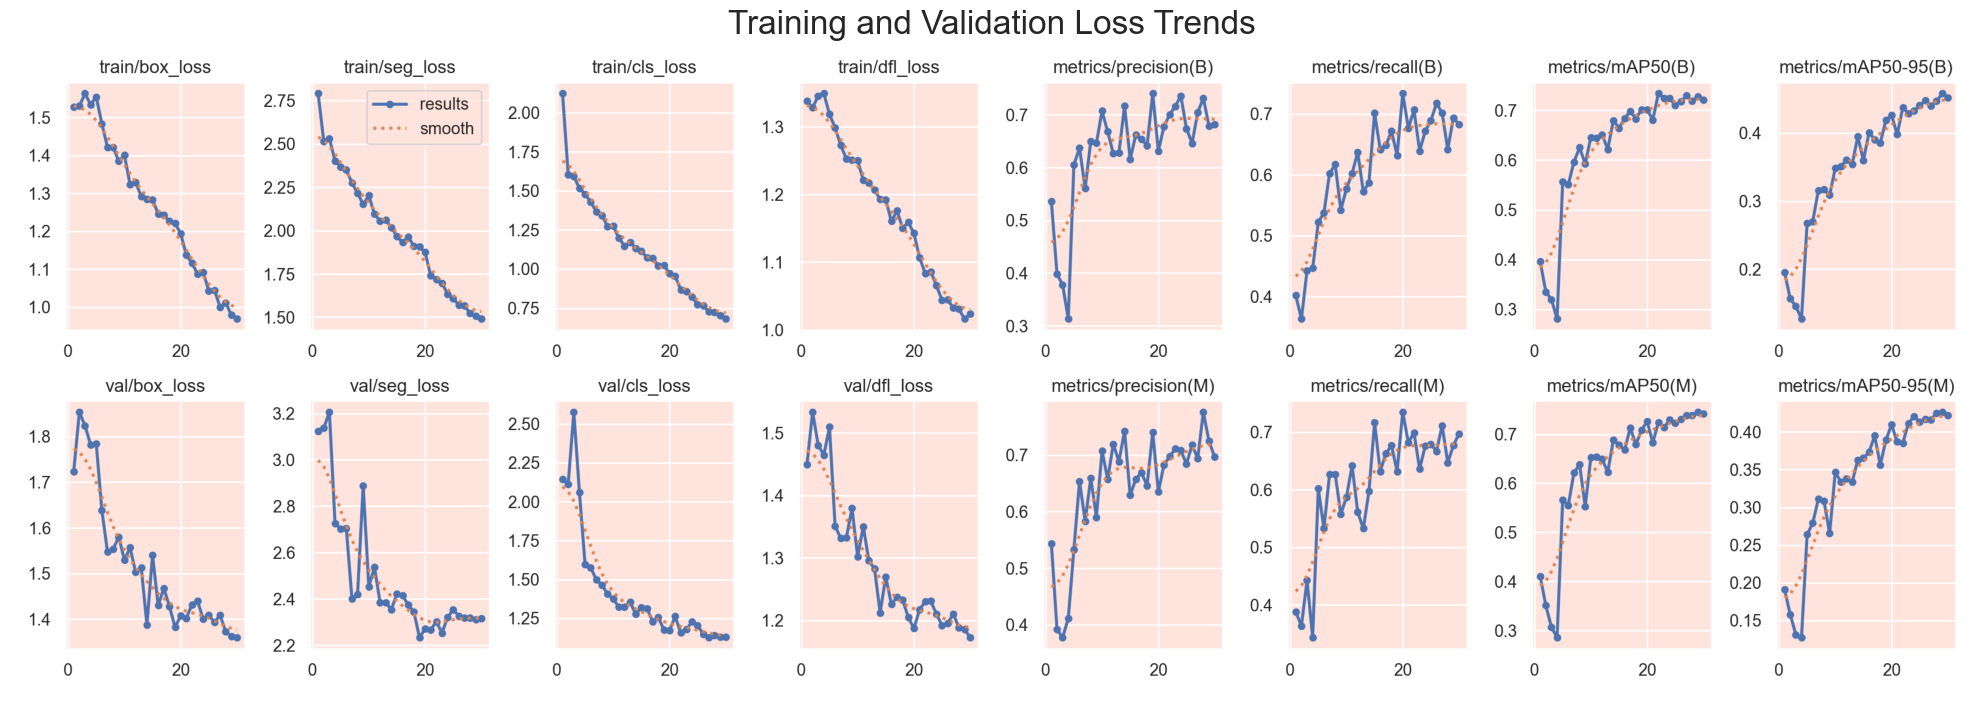

✓ Results visualization loaded from: runs\segment\train2\results.png


In [37]:
# Load and display training results visualization
results_file_path = post_training_files_path / 'results.png'

try:
    if not results_file_path.exists():
        raise FileNotFoundError(f"Results file not found: {results_file_path}")
    
    # Read the image using cv2
    image = cv2.imread(str(results_file_path))
    if image is None:
        raise ValueError(f"Could not read image from: {results_file_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

    # Display the image using matplotlib
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.imshow(image)
    ax.set_title('Training and Validation Loss Trends', fontsize=24)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"✓ Results visualization loaded from: {results_file_path}")
except Exception as e:
    print(f"✗ Error loading results: {e}")

In [49]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title, ylim_range=[0,2]):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='blue', linestyle='-', linewidth=2, ax=ax)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='#ed2f00', linestyle='--', linewidth=2, ax=ax)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Epochs', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_ylim(ylim_range)
    ax.legend(fontsize=11)
    plt.tight_layout()
    plt.show()

✓ Loaded training metrics: 30 epochs
  Columns: epoch, time, train/box_loss, train/seg_loss, train/cls_loss...


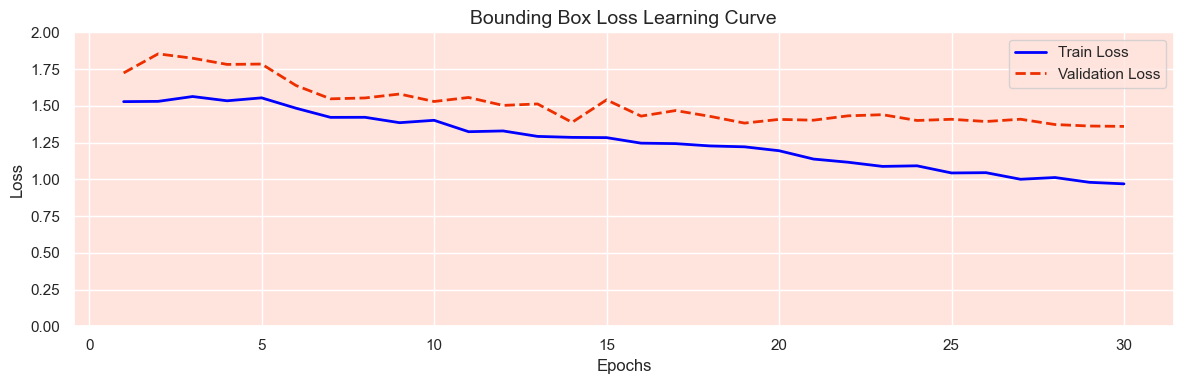

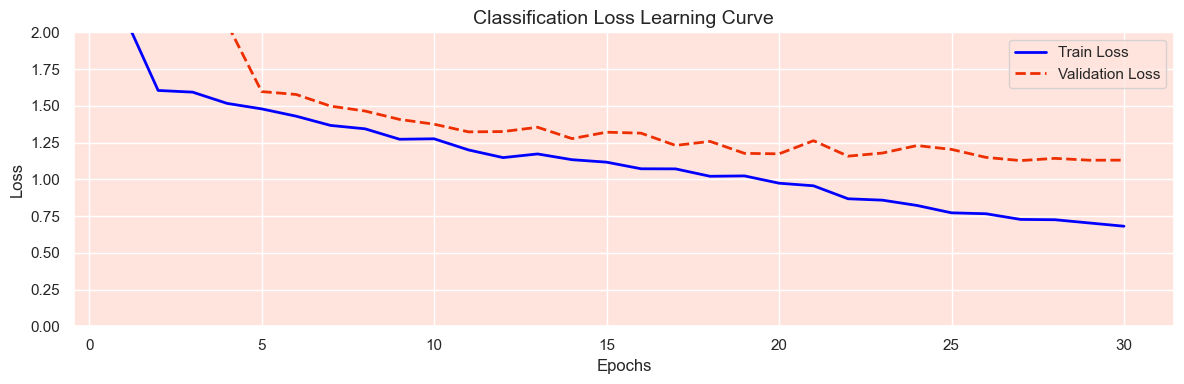

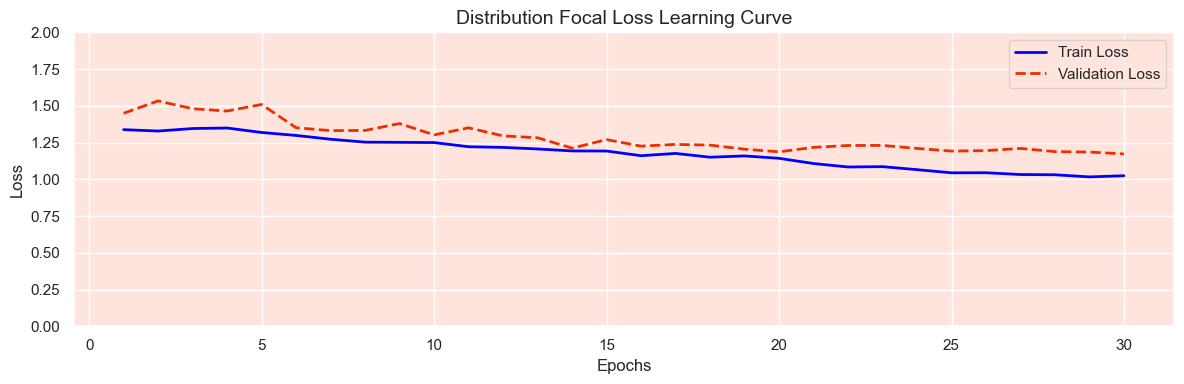

In [50]:
# Load and analyze training metrics from CSV
results_csv_path = post_training_files_path / 'results.csv'

try:
    if not results_csv_path.exists():
        raise FileNotFoundError(f"Results CSV not found: {results_csv_path}")
    
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(results_csv_path)
    
    # Remove any leading whitespace from the column names
    df.columns = df.columns.str.strip()
    
    print(f"✓ Loaded training metrics: {len(df)} epochs")
    print(f"  Columns: {', '.join(df.columns.tolist()[:5])}...")
    
    # Plot the learning curves for each loss
    plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Bounding Box Loss Learning Curve')
    plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
    plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')
    
except Exception as e:
    print(f"✗ Error loading/plotting metrics: {e}")

Threshold Metrics Anaylsis

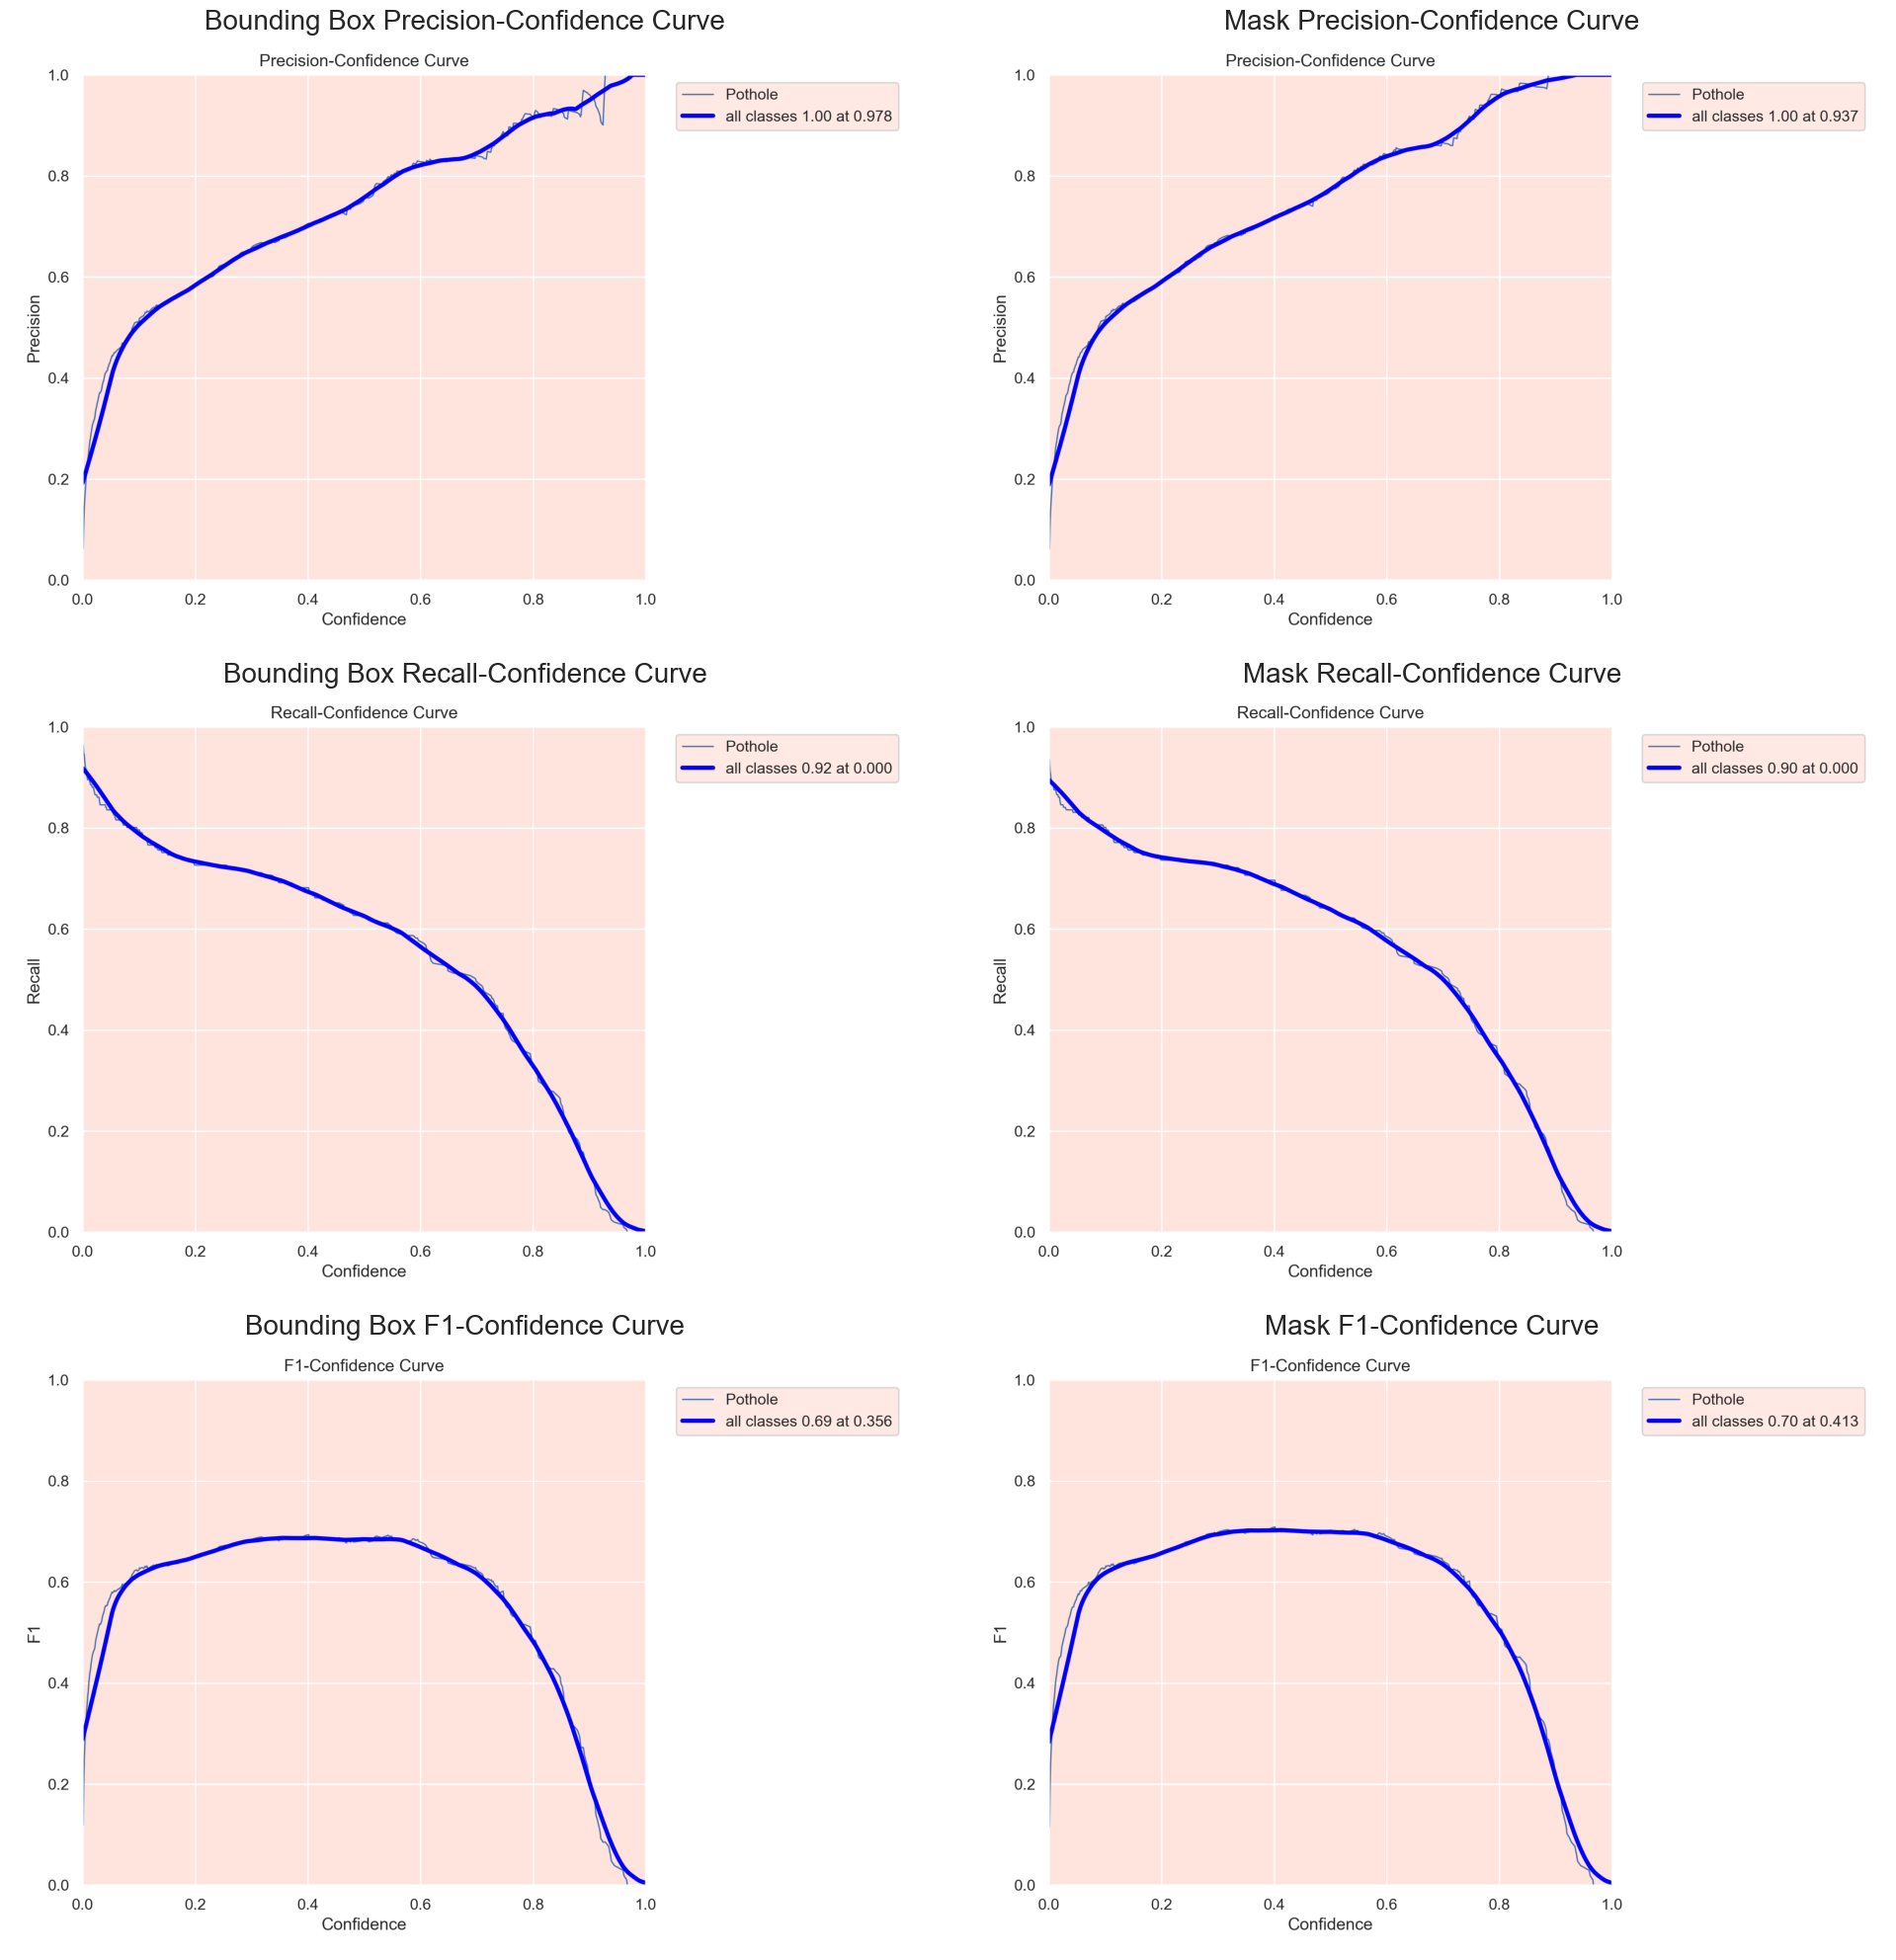

✓ Threshold metrics analysis completed


In [40]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
box_files_titles = {
    'BoxP_curve.png': 'Bounding Box Precision-Confidence Curve',
    'BoxR_curve.png': 'Bounding Box Recall-Confidence Curve',
    'BoxF1_curve.png': 'Bounding Box F1-Confidence Curve'
}
mask_files_titles = {
    'MaskP_curve.png': 'Mask Precision-Confidence Curve',
    'MaskR_curve.png': 'Mask Recall-Confidence Curve',
    'MaskF1_curve.png': 'Mask F1-Confidence Curve'
}

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Function to read and convert image for plotting
def read_and_convert_image(file_path: Path) -> Optional[np.ndarray]:
    """Read and convert image from BGR to RGB format."""
    try:
        image = cv2.imread(str(file_path))
        if image is None:
            print(f"Warning: Could not read image: {file_path}")
            return None
        return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return None

# Plot 'Box' images in the first column with meaningful titles
for i, (filename, title) in enumerate(box_files_titles.items()):
    img_path = post_training_files_path / filename
    img = read_and_convert_image(img_path)
    if img is not None:
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(title, fontsize=20)
    else:
        axs[i, 0].text(0.5, 0.5, f'File not found:\n{filename}', 
                      ha='center', va='center', fontsize=12)
    axs[i, 0].axis('off') 

# Plot 'Mask' images in the second column with meaningful titles
for i, (filename, title) in enumerate(mask_files_titles.items()):
    img_path = post_training_files_path / filename
    img = read_and_convert_image(img_path)
    if img is not None:
        axs[i, 1].imshow(img)
        axs[i, 1].set_title(title, fontsize=20)
    else:
        axs[i, 1].text(0.5, 0.5, f'File not found:\n{filename}', 
                      ha='center', va='center', fontsize=12)
    axs[i, 1].axis('off')  

plt.tight_layout()
plt.show()
print("✓ Threshold metrics analysis completed")

Precision Recall Curve Analysis

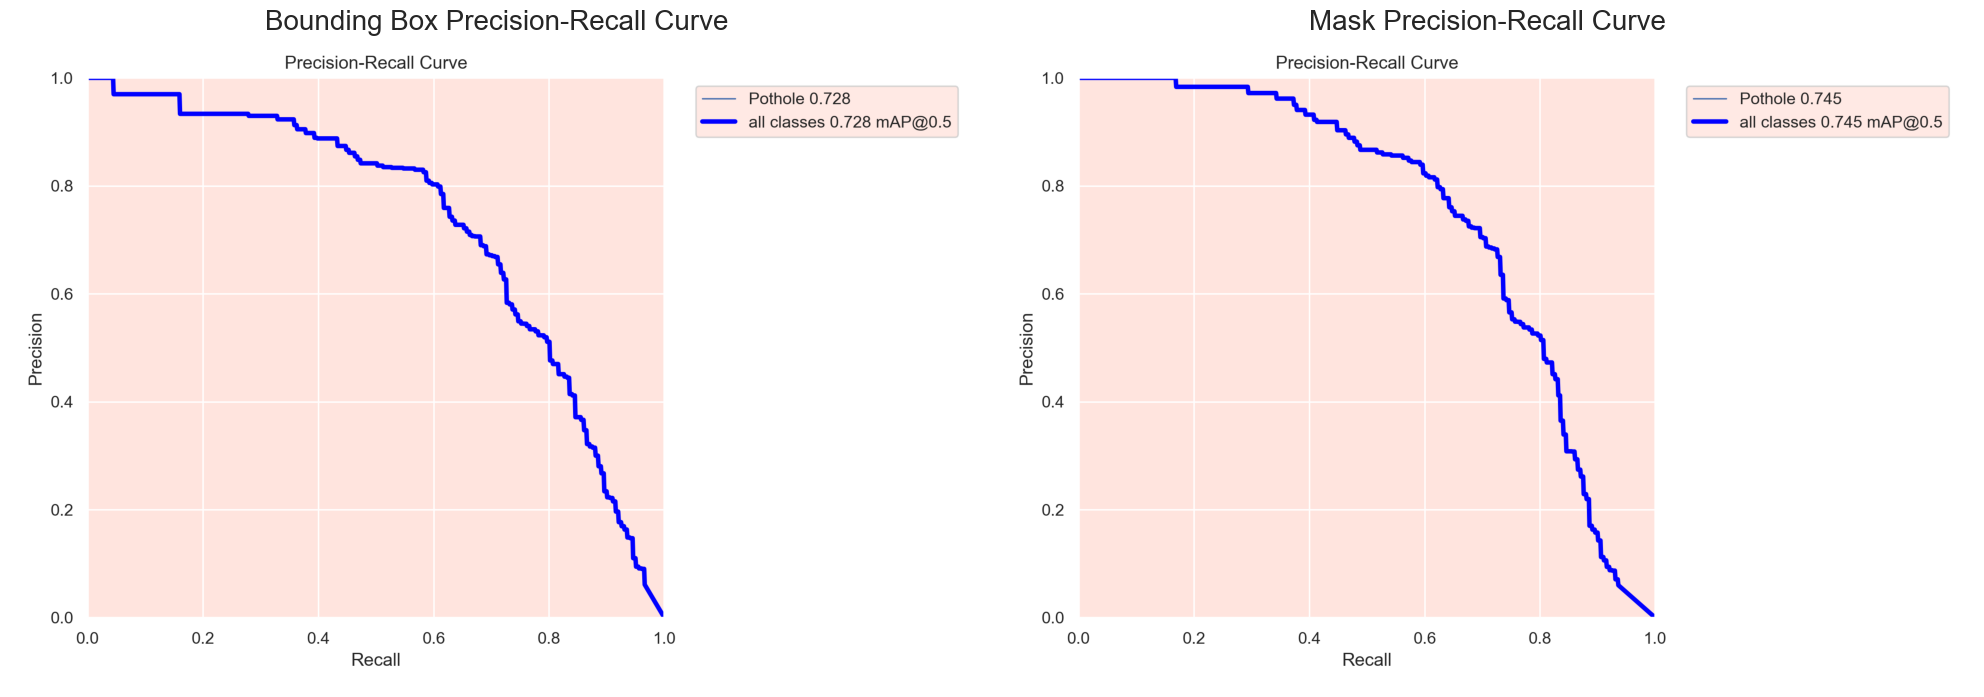

✓ Precision-Recall curve analysis completed


In [41]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
pr_files_titles = {
    'BoxPR_curve.png': 'Bounding Box Precision-Recall Curve',
    'MaskPR_curve.png': 'Mask Precision-Recall Curve'
}

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 'Box' and 'Mask' images in the subplot with meaningful titles
for i, (filename, title) in enumerate(pr_files_titles.items()):
    img_path = post_training_files_path / filename
    img = read_and_convert_image(img_path)
    if img is not None:
        axs[i].imshow(img)
        axs[i].set_title(title, fontsize=20)
    else:
        axs[i].text(0.5, 0.5, f'File not found:\n{filename}', 
                   ha='center', va='center', fontsize=12)
    axs[i].axis('off')

plt.tight_layout()
plt.show()
print("✓ Precision-Recall curve analysis completed")

Confusion Matrix Analysis

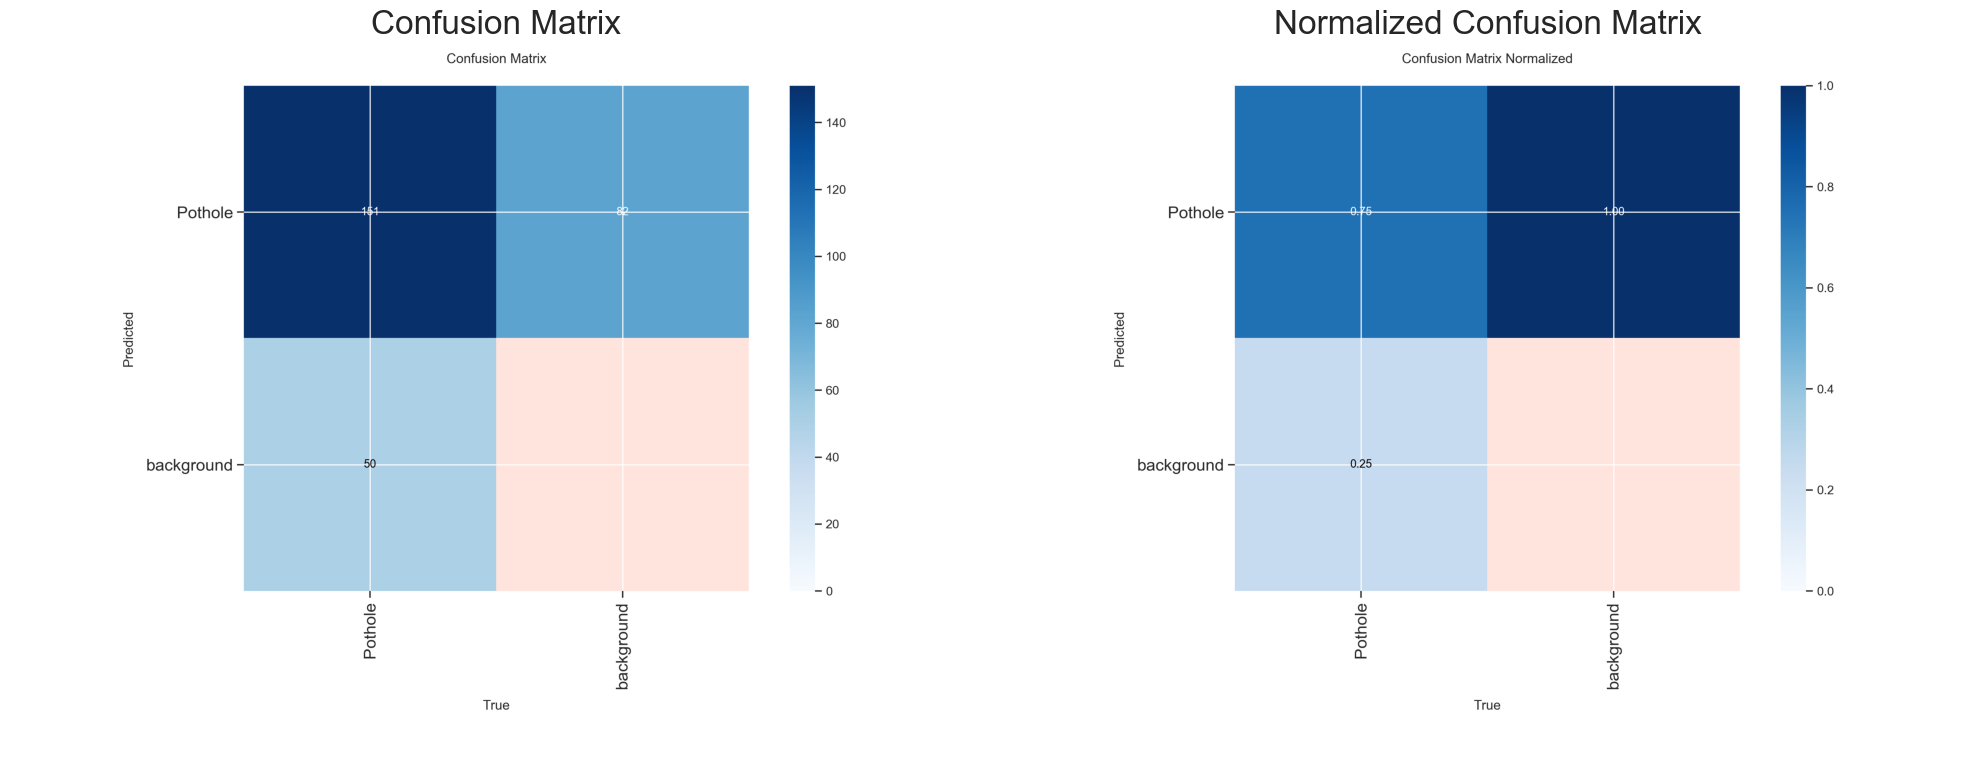

✓ Confusion matrix analysis completed


In [42]:
# Construct the path to the confusion matrix images
confusion_matrix_path = post_training_files_path / 'confusion_matrix.png'
confusion_matrix_normalized_path = post_training_files_path / 'confusion_matrix_normalized.png'

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Read and convert both images
cm_img = read_and_convert_image(confusion_matrix_path)
cm_norm_img = read_and_convert_image(confusion_matrix_normalized_path)

# Display the images
if cm_img is not None:
    axs[0].imshow(cm_img)
    axs[0].set_title('Confusion Matrix', fontsize=24)
else:
    axs[0].text(0.5, 0.5, 'Confusion Matrix\nnot found', 
               ha='center', va='center', fontsize=16)
axs[0].axis('off')

if cm_norm_img is not None:
    axs[1].imshow(cm_norm_img)
    axs[1].set_title('Normalized Confusion Matrix', fontsize=24)
else:
    axs[1].text(0.5, 0.5, 'Normalized Confusion Matrix\nnot found', 
               ha='center', va='center', fontsize=16)
axs[1].axis('off')

plt.tight_layout()
plt.show()
print("✓ Confusion matrix analysis completed")

Performance Metric Assessment

In [43]:
# Construct the path to the best model weights file
best_model_path = post_training_files_path / 'weights' / 'best.pt'

try:
    if not best_model_path.exists():
        raise FileNotFoundError(f"Best model weights not found: {best_model_path}")
    
    # Load the best model weights into the YOLO model
    print(f"Loading best model from: {best_model_path}")
    best_model = YOLO(str(best_model_path))
    
    # Validate the best model using the validation set with default parameters
    print("Validating model on validation set...")
    metrics = best_model.val(split='val')
    
    # Convert the dictionary to a pandas DataFrame and use the keys as the index
    metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])
    
    print("\n✓ Model validation completed")
    print("\nPerformance Metrics:")
    print("=" * 50)
    display(metrics_df.round(3))
    
except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    print("Please ensure training completed successfully and best.pt exists.")
except Exception as e:
    print(f"✗ Error during validation: {e}")
    raise

Loading best model from: runs\segment\train2\weights\best.pt
Validating model on validation set...
Ultralytics 8.3.237  Python-3.14.2 torch-2.9.1+cpu CPU (Intel Core i7-14700F)


YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 11.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 638.590.2 MB/s, size: 100.6 KB)
val: Scanning C:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\valid\labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 60/60 112.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 3.2it/s 1.2s0.5s
                   all         60        201      0.677      0.692      0.728      0.458      0.724      0.677      0.745      0.426
Speed: 0.2ms preprocess, 13.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to C:\Users\User\Documents\Programming\pothole_detection\runs\segment\val

✓ Model validation completed

Performance Metrics:


Metric Value
metrics/precision(B)         0.677
metrics/recall(B)            0.692
metrics/mAP50(B)             0.728
metrics/mAP50-95(B)          0.458
metrics/precision(M)         0.724
metrics/recall(M)            0.677
metrics/mAP50(M)             0.745
metrics/mAP50-95(M)          0.426
fitness                      0.885

Testing Image

Testing on 16 random validation images...


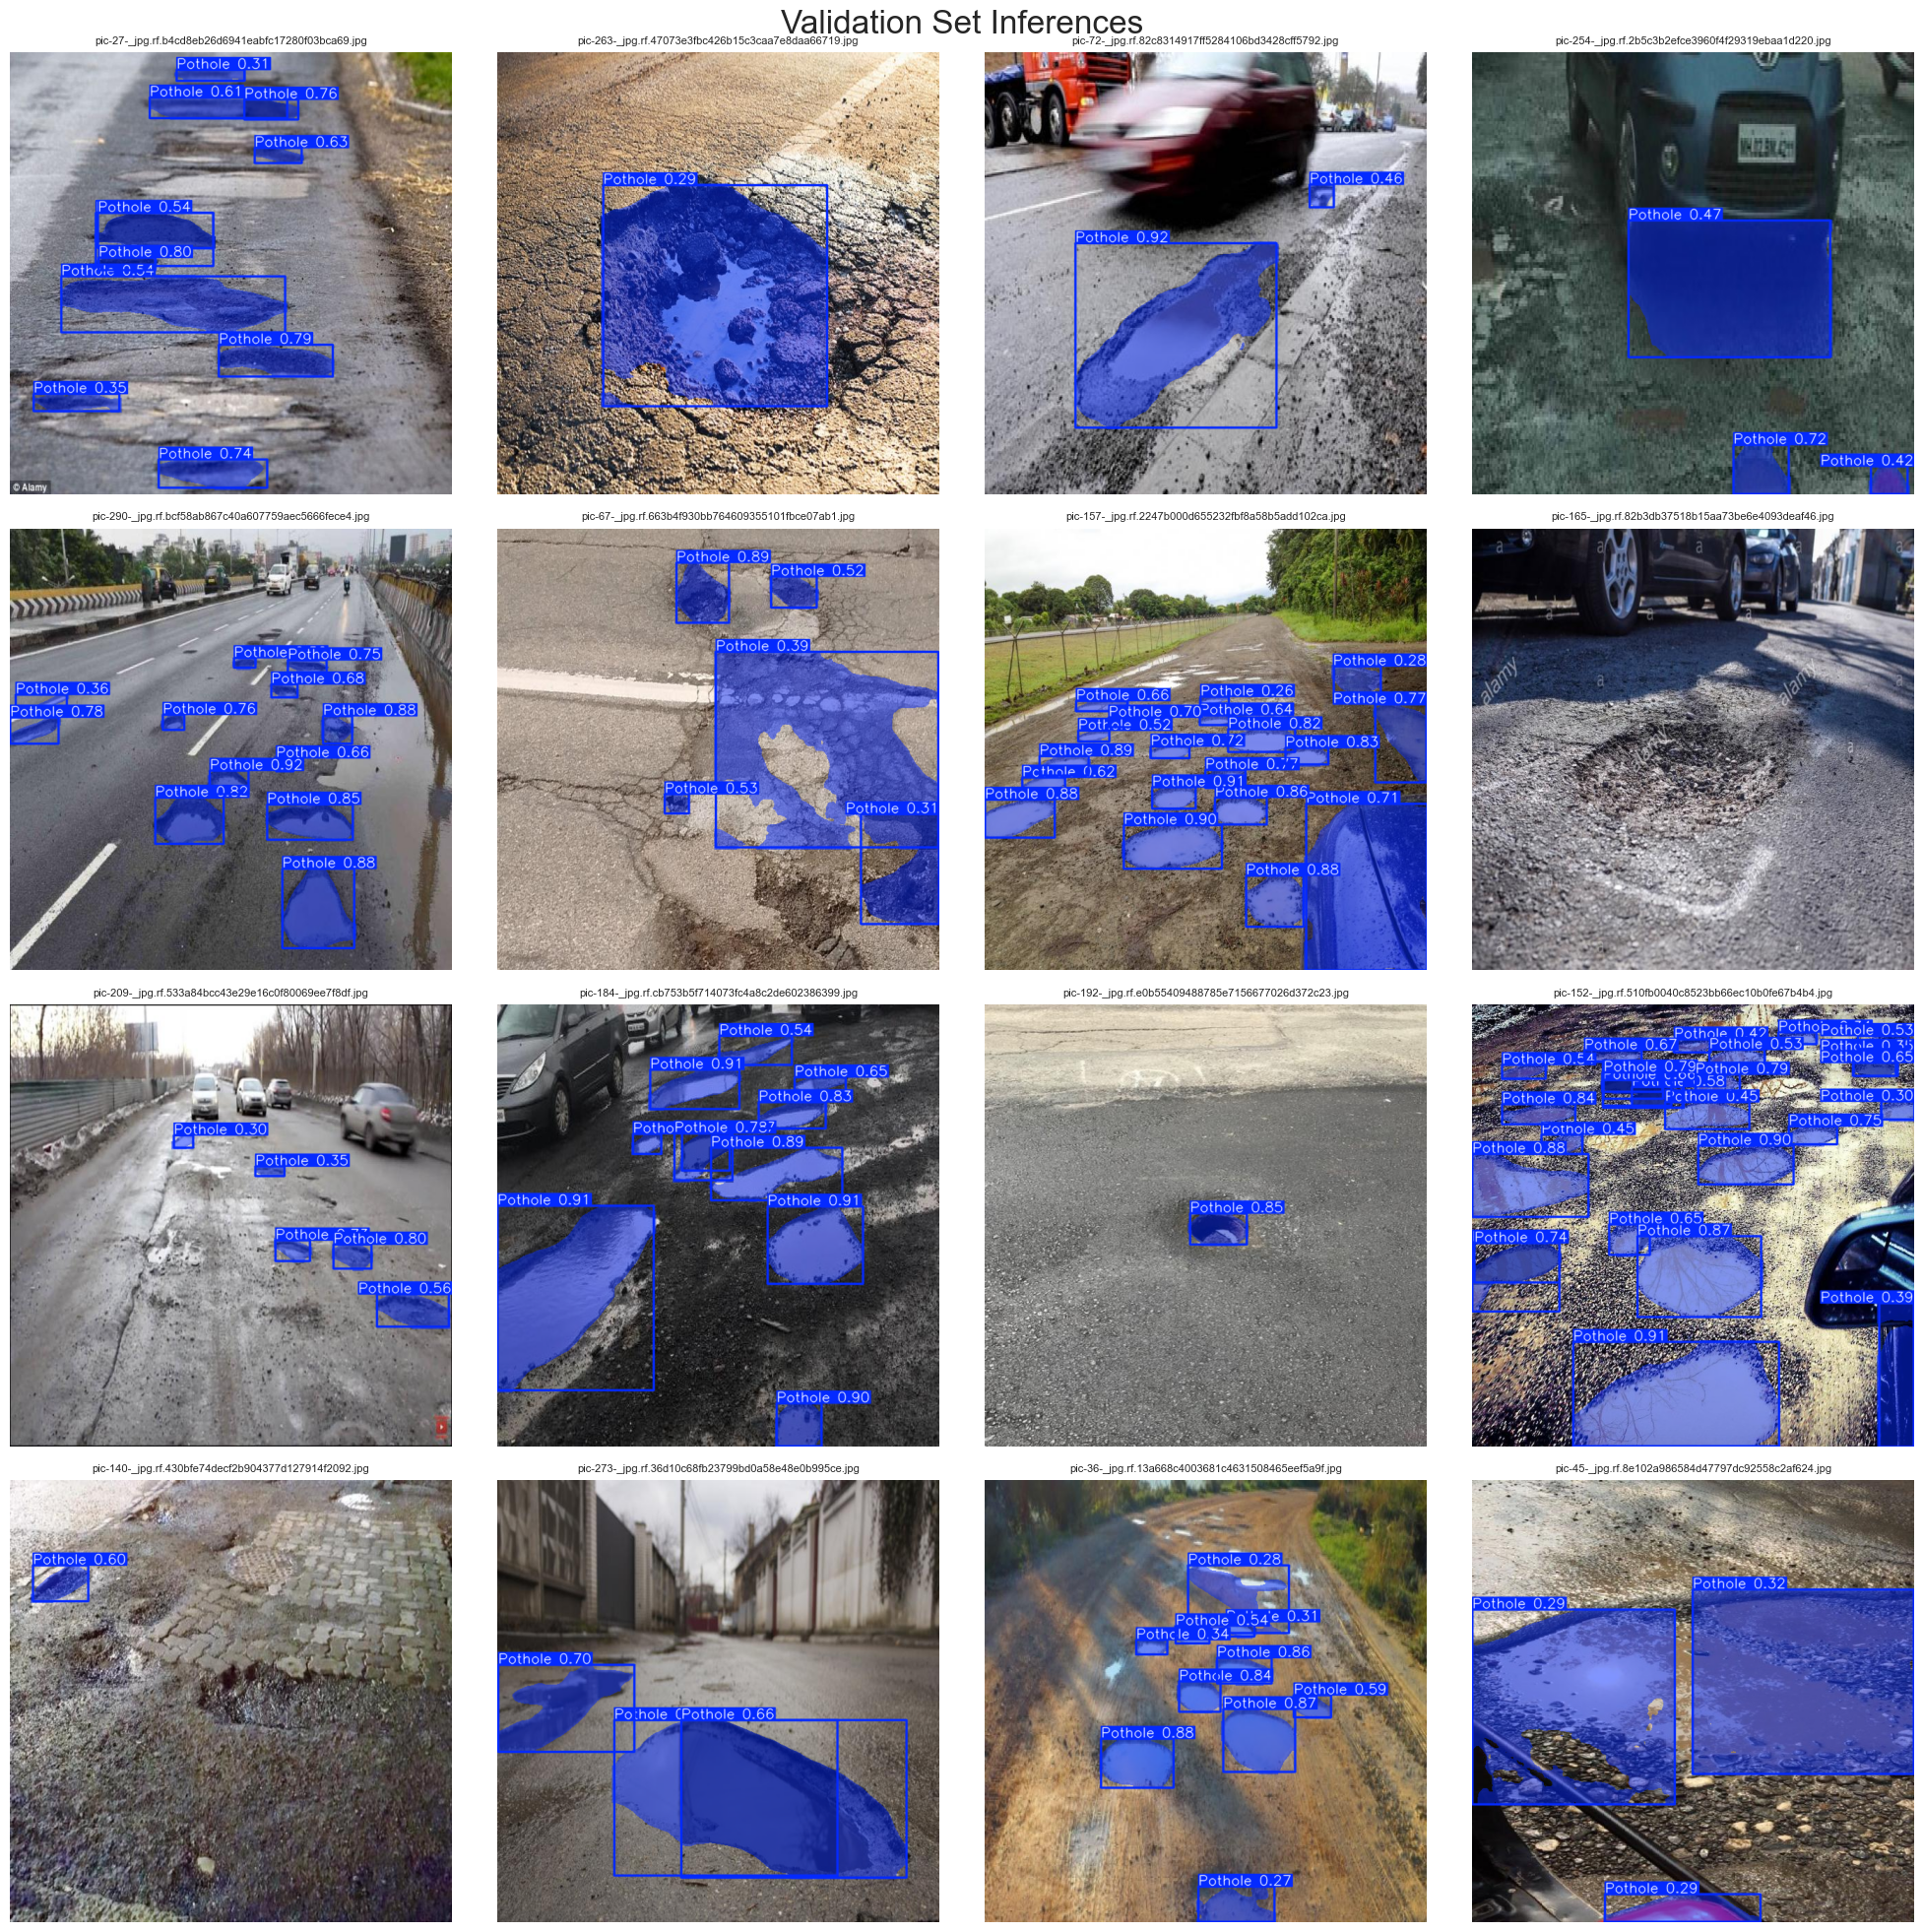

✓ Validation inference completed


In [44]:
import random

# Define the path to the validation images
valid_images_path = DATASET_PATH / 'valid' / 'images'

try:
    if not valid_images_path.exists():
        raise FileNotFoundError(f"Validation images path not found: {valid_images_path}")
    
    # List all image files in the directory (support multiple formats)
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_files = [
        f for f in valid_images_path.iterdir() 
        if f.suffix.lower() in image_extensions
    ]
    
    if not image_files:
        raise ValueError(f"No image files found in: {valid_images_path}")
    
    # Select random images (up to 16, or all if less than 16)
    num_images = min(16, len(image_files))
    selected_images = random.sample(image_files, num_images)
    
    print(f"Testing on {num_images} random validation images...")
    
    # Initialize the subplot
    rows = (num_images + 3) // 4  # Calculate rows needed
    fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('Validation Set Inferences', fontsize=24)
    
    # Perform inference on each selected image and display it
    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            image_path = selected_images[i]
            try:
                results = best_model.predict(source=str(image_path), imgsz=640, verbose=False)
                annotated_image = results[0].plot()
                annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
                ax.imshow(annotated_image_rgb)
                ax.set_title(image_path.name, fontsize=8)
            except Exception as e:
                ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}', 
                       ha='center', va='center', fontsize=8)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    print("✓ Validation inference completed")
    
except Exception as e:
    print(f"✗ Error during validation inference: {e}")
    raise


Test Video

In [52]:
# Test model on video file
video_path = VIDEO_TEST_PATH

try:
    if not video_path.exists():
        print(f"⚠️  Warning: Video file not found: {video_path}")
        print("Please update VIDEO_TEST_PATH or ensure the video file exists.")
        print(f"Current VIDEO_TEST_PATH: {VIDEO_TEST_PATH}")
    else:
        print(f"Processing video: {video_path}")
        print("This may take a while depending on video length...")
        
        # Initiate pothole detection on the sample video using the best performing model
        # Using stream=True to avoid memory issues with large videos
        results = best_model.predict(
            source=str(video_path),
            save=True,
            imgsz=320,
            half=True,
            stream=True,  # Use streaming to avoid memory issues
            verbose=True
        )
        
        # Process results (if needed for further analysis)
        for result in results:
            pass  # Results are automatically saved
        
        print(f"\n✓ Video processing completed!")
        print(f"  Output saved to: runs/segment/predict/")
        
except Exception as e:
    print(f"✗ Error processing video: {e}")
    print("Please check that the video file exists and is a valid video format.")

Processing video: Pothole_Segmentation_YOLOv8\sample_video.mp4
This may take a while depending on video length...

video 1/1 (frame 1/375) c:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\sample_video.mp4: 192x320 3 Potholes, 15.3ms
video 1/1 (frame 2/375) c:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\sample_video.mp4: 192x320 2 Potholes, 10.3ms
video 1/1 (frame 3/375) c:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\sample_video.mp4: 192x320 1 Pothole, 16.5ms
video 1/1 (frame 4/375) c:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\sample_video.mp4: 192x320 3 Potholes, 9.6ms
video 1/1 (frame 5/375) c:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\sample_video.mp4: 192x320 2 Potholes, 9.6ms
video 1/1 (frame 6/375) c:\Users\User\Documents\Programming\pothole_detection\Pothole_Segmentation_YOLOv8\sample_video.mp4: 192x320 1

In [59]:
# Convert AVI videos to MP4 format in the predict folder
import subprocess
import os
import shutil
from pathlib import Path

def find_ffmpeg():
    """Find ffmpeg executable in common locations or PATH"""
    # First try to find in PATH
    ffmpeg_path = shutil.which('ffmpeg')
    if ffmpeg_path:
        return ffmpeg_path
    
    # Common Windows installation paths
    common_paths = [
        r'C:\ffmpeg\bin\ffmpeg.exe',
        r'C:\Program Files\ffmpeg\bin\ffmpeg.exe',
        r'C:\Users\{}\AppData\Local\Microsoft\WinGet\Packages\Gyan.FFmpeg_Microsoft.Winget.Source_8wekyb3d8bbwe\ffmpeg-8.0.1-full_build\bin\ffmpeg.exe'.format(os.getenv('USERNAME')),
        r'C:\tools\ffmpeg\bin\ffmpeg.exe',
    ]
    
    # Search for ffmpeg in WinGet packages folder
    winget_base = Path(os.getenv('LOCALAPPDATA', '')) / 'Microsoft' / 'WinGet' / 'Packages'
    if winget_base.exists():
        for package_dir in winget_base.iterdir():
            if 'FFmpeg' in package_dir.name or 'ffmpeg' in package_dir.name.lower():
                ffmpeg_exe = package_dir / 'ffmpeg-8.0.1-full_build' / 'bin' / 'ffmpeg.exe'
                if ffmpeg_exe.exists():
                    return str(ffmpeg_exe)
                # Also check for other version numbers
                for subdir in package_dir.iterdir():
                    if subdir.is_dir() and 'ffmpeg' in subdir.name.lower():
                        ffmpeg_exe = subdir / 'bin' / 'ffmpeg.exe'
                        if ffmpeg_exe.exists():
                            return str(ffmpeg_exe)
    
    # Check common paths
    for path in common_paths:
        if Path(path).exists():
            return path
    
    return None

predict_folder = Path('runs/segment/predict')

try:
    if not predict_folder.exists():
        print(f"⚠️  Warning: Predict folder not found: {predict_folder}")
        print("Please ensure the video processing has been completed first.")
    else:
        # Find ffmpeg executable
        ffmpeg_path = find_ffmpeg()
        if not ffmpeg_path:
            print("✗ Error: ffmpeg not found.")
            print("  Please install ffmpeg or restart the Jupyter kernel after installation.")
            print("  Install instructions: https://ffmpeg.org/download.html")
        else:
            print(f"✓ Found ffmpeg at: {ffmpeg_path}")
            
            # Find all .avi files in the predict folder
            avi_files = list(predict_folder.glob('*.avi'))
            
            if not avi_files:
                print("No AVI files found in the predict folder.")
            else:
                print(f"\nFound {len(avi_files)} AVI file(s) to convert:")
                for avi_file in avi_files:
                    print(f"  - {avi_file.name}")
                
                # Convert each AVI file to MP4
                for avi_file in avi_files:
                    mp4_file = avi_file.with_suffix('.mp4')
                    
                    if mp4_file.exists():
                        print(f"\n⚠️  {mp4_file.name} already exists. Skipping {avi_file.name}.")
                        continue
                    
                    print(f"\nConverting {avi_file.name} to {mp4_file.name}...")
                    
                    try:
                        # Use ffmpeg to convert AVI to MP4
                        # -y flag overwrites output file if it exists
                        result = subprocess.run([
                            ffmpeg_path,
                            '-i', str(avi_file),
                            '-c:v', 'libx264',
                            '-preset', 'medium',
                            '-crf', '23',
                            '-c:a', 'aac',
                            '-b:a', '128k',
                            '-y',  # Overwrite output file if exists
                            str(mp4_file)
                        ], check=True, capture_output=True, text=True)
                        
                        print(f"✓ Successfully converted: {mp4_file.name}")
                        
                    except subprocess.CalledProcessError as e:
                        print(f"✗ Error converting {avi_file.name}: {e.stderr}")
                    except Exception as e:
                        print(f"✗ Error converting {avi_file.name}: {e}")
                
                print("\n✓ Video conversion process completed!")
            
except Exception as e:
    print(f"✗ Error: {e}")



✓ Found ffmpeg at: C:\Users\User\AppData\Local\Microsoft\WinGet\Packages\Gyan.FFmpeg_Microsoft.Winget.Source_8wekyb3d8bbwe\ffmpeg-8.0.1-full_build\bin\ffmpeg.exe

Found 1 AVI file(s) to convert:
  - sample_video.avi

Converting sample_video.avi to sample_video.mp4...
✓ Successfully converted: sample_video.mp4

✓ Video conversion process completed!
